# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use model selection for performing some simple analysis on real neural signals. 

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders
* Select the optimal model via cross-validation

The last stage of the lab uses LASSO estimation for model selection.  If you are doing this part of the lab, you should review the concepts in [LASSO demonstration](./prostate.ipynb) on the prostate cancer  dataset.  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the basic packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [2]:
import scipy.io
mat_dict = scipy.io.loadmat('StevensonV2.mat')

The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [3]:
mat_dict.keys()

['handPos',
 'spikes',
 'timeBase',
 'Publication',
 'handVel',
 '__header__',
 '__globals__',
 'startBins',
 'startBinned',
 'time',
 '__version__',
 'targets',
 'target']

We extract two variables, `spikes` and `handVel`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand velocity.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handVel` data, we take the first component which is the motion in the $x$-direction.

In [4]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handVel'][0,:]

The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [5]:
nt,nneuron = X0.shape
print "nt = %d" %nt
print "nneuron = %d" %nneuron

nt = 15536
nneuron = 196


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [6]:
time = mat_dict['time'][0,:]
tsamp = time[1] - time[0]
ttotal = time[-1]-time[0]
print time
print "sampling time = %f" %tsamp
print "total duration = %f" %ttotal

[  12.591   12.641   12.691 ...,  789.241  789.291  789.341]
sampling time = 0.050000
total duration = 776.750000


## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [7]:
# Number of samples for training and test
ntr = nt // 2
nts = nt - ntr

# Training
Xtr = X0[:ntr]
ytr = y0[:ntr]
print Xtr.shape
print ytr.shape
# Test
Xts = X0[ntr:]
yts = y0[ntr:]

(7768L, 196L)
(7768L,)


Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [8]:
import sklearn
from sklearn import *
regr = linear_model.LinearRegression()
regr.fit(Xtr,ytr)

c:\python271\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\python271\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
c:\python271\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
c:\python271\lib\site-packages\sklearn\learning_curve.py:

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Measure and print the normalized RSS on the test data.  

In [9]:
yts_pred = regr.predict(Xts)
RSS = np.mean((yts_pred-yts)**2)/(np.std(yts)**2)
print("Normalized RSS={0:f}".format(RSS))

Normalized RSS=1834410385380352983040.000000


You should see that the test error is enormous -- the model does not generalize to the test data at all. 

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

c:\python271\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


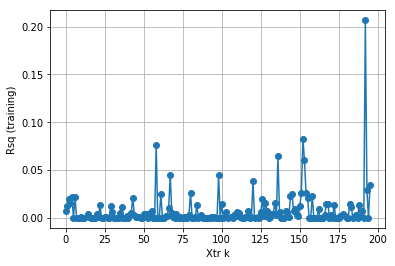

In [10]:
ym = np.mean(ytr)
syy = np.mean((ytr-ym)**2)
Rsq = np.zeros(nneuron)

for k in range(nneuron):
    xm = np.mean(Xtr[:,k])
    sxy = np.mean((Xtr[:,k]-xm)*(ytr-ym))
    sxx = np.mean((Xtr[:,k]-xm)**2)
    Rsq[k] = (sxy)**2/sxx/syy
    
x = np.array(range(nneuron))
plt.plot(x,Rsq,'o-')
plt.xlabel('Xtr k')
plt.ylabel('Rsq (training)')
plt.grid()
    

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=100` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [11]:
d = 100  # Number of neurons to use

Isel = np.argsort(-Rsq)[:100]
print("The neurons with the ten highest R^2 values =")
print Isel[:10]

The neurons with the ten highest R^2 values =
[192 152  58 136 153  67  98 120 195 193]


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [12]:
Iseld = np.argsort(-Rsq)[100:]
Xtrh = np.delete(Xtr,Iseld,axis = 1)
regr.fit(Xtrh,ytr)

Xtsh = np.delete(Xts,Iseld,axis = 1)
yts_pred = regr.predict(Xtsh)

RSSp = ((yts_pred-yts)**2)/(yts**2)
print RSSp

RSS = np.mean((yts_pred-yts)**2)/(np.std(yts)**2)
print("Normalized RSS={0:f}".format(RSS))

[ 0.54788764  0.42063717  0.27364107 ...,  0.89771315  0.19029546
  0.46682734]
Normalized RSS=0.514133


Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

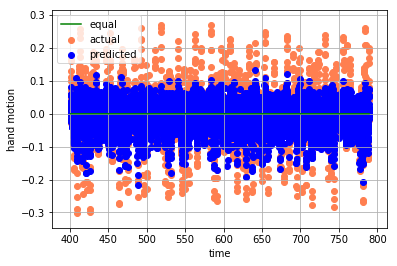

In [13]:
plt.scatter(time[ntr:],yts,label = "actual",color ="coral")
plt.scatter(time[ntr:],yts_pred,label = "predicted",color ="blue")
plt.plot(time[ntr:],yts==yts_pred,label = "equal",color = "green")
plt.xlabel('time')
plt.ylabel('hand motion')
plt.grid()
plt.legend(loc='upper left')

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=100`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

In [14]:
import  sklearn.model_selection 

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest) 

# Loop over the folds
RSSts = np.zeros((nd,nfold))
for isplit, Ind in enumerate(kf.split(X0)):
        
    # Get the training data in the split
    Itr, Its = Ind
    Xtr = X0[Itr]
    ytr = y0[Itr]
    Xts = X0[Its]
    yts = y0[Its]
    
    for it, d in enumerate(dtest):
    
        # Fit data on training data
        Iseld = np.argsort(-Rsq)[d:] 
        Xtrh = np.delete(Xtr,Iseld,axis = 1)
        regr.fit(Xtrh,ytr)
        
        # Measure RSS on test data
        Xtsh = np.delete(Xts,Iseld,axis = 1)
        yts_pred = regr.predict(Xtsh)
        RSSts[it,isplit] = np.mean((yts_pred-yts)**2)
        print "d = %d" %d ,"it = %d" %it
        print "RSS = %f" %RSSts[it,isplit]


d = 10 it = 0
RSS = 0.001743
d = 20 it = 1
RSS = 0.001667
d = 30 it = 2
RSS = 0.001650
d = 40 it = 3
RSS = 0.001612
d = 50 it = 4
RSS = 0.001587
d = 60 it = 5
RSS = 0.001555
d = 70 it = 6
RSS = 0.001534
d = 80 it = 7
RSS = 0.001509
d = 90 it = 8
RSS = 0.001506
d = 100 it = 9
RSS = 0.001503
d = 110 it = 10
RSS = 0.001506
d = 120 it = 11
RSS = 0.001504
d = 130 it = 12
RSS = 0.001467
d = 140 it = 13
RSS = 0.001473
d = 150 it = 14
RSS = 0.001472
d = 160 it = 15
RSS = 0.001459
d = 170 it = 16
RSS = 0.001460
d = 180 it = 17
RSS = 0.001459
d = 190 it = 18
RSS = 1135811414323874.000000
d = 10 it = 0
RSS = 0.001927
d = 20 it = 1
RSS = 0.001786
d = 30 it = 2
RSS = 0.001749
d = 40 it = 3
RSS = 0.001687
d = 50 it = 4
RSS = 0.001671
d = 60 it = 5
RSS = 0.001630
d = 70 it = 6
RSS = 0.001612
d = 80 it = 7
RSS = 0.001581
d = 90 it = 8
RSS = 0.001568
d = 100 it = 9
RSS = 0.001566
d = 110 it = 10
RSS = 0.001564
d = 120 it = 11
RSS = 0.001552
d = 130 it = 12
RSS = 0.001497
d = 140 it = 13
RSS = 0.001490


Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method. 

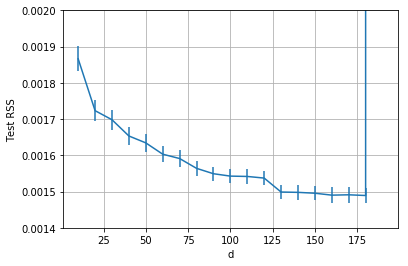

In [15]:
RSSts_mean = np.mean(RSSts, axis = 1)
RSSts_std = np.std(RSSts,axis=1) / np.sqrt(nfold-1)
plt.errorbar(dtest, RSSts_mean, yerr=RSSts_std, fmt='-')
plt.ylim(0.0014,0.002)
plt.xlabel('d')
plt.ylabel('Test RSS')
plt.grid()

Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [16]:
# Find the minimum RSS target
imin = np.argmin(RSSts_mean)
RSSts_tgt = RSSts_mean[imin] + RSSts_std[imin]

# Find the lowest model order below the target
I = np.where(RSSts_mean <= RSSts_tgt)[0]
iopt = I[0] 
dopt = dtest[iopt]

# Print results
print("The estimated model order is %d" % dopt)
print("the mean test RSS per sample at the optimal d is:"), np.mean(RSSts[iopt,:]) 

The estimated model order is 130
the mean test RSS per sample at the optimal d is: 0.00149871513194


## Using LASSO regression

Instead of using the above heuristic to select the variables, we can use LASSO regression.  

First use the `preprocessing.scale` method to standardize the data matrix `X0`.  Store the standardized values in `Xs`.  You do not need to standardize the response.  For this data, the `scale` routine may throw a warning that you are converting data types.  That is fine.

In [17]:
from sklearn import preprocessing

Xs = preprocessing.scale(X0)
ys = y0

c:\python271\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Now, use the LASSO method to fit a model.  Use cross validation to select the regularization level `alpha`.  Use `alpha` values logarithmically spaced from `1e-5` to `0.1`, and use 10 fold cross validation.  

In [18]:
import  sklearn.model_selection 

# Create a k-fold cross validation object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Create the LASSO model.  We use the `warm start` parameter so that the fit will start at the previous value.
# This speeds up the fitting.
model = linear_model.Lasso(warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-5,-1,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(Xs)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = Xs[Itr,:]
    y_tr = ys[Itr]
    X_ts = Xs[Its,:]
    y_ts = ys[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        model.alpha = a
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)
        print "ia = %d" %ia,"ifold = %d" %ifold
        print mse[ia,ifold]

ia = 0 ifold = 0
0.00151289823609
ia = 1 ifold = 0
0.00151285862117
ia = 2 ifold = 0
0.00151281467289
ia = 3 ifold = 0
0.00151276587878
ia = 4 ifold = 0
0.00151271402991
ia = 5 ifold = 0
0.00151265492145
ia = 6 ifold = 0
0.00151259126739
ia = 7 ifold = 0
0.00151252059824
ia = 8 ifold = 0
0.00151244422025
ia = 9 ifold = 0
0.00151236179028
ia = 10 ifold = 0
0.00151227305796
ia = 11 ifold = 0
0.00151217770043
ia = 12 ifold = 0
0.00151207548456
ia = 13 ifold = 0
0.00151196944695
ia = 14 ifold = 0
0.00151185962251
ia = 15 ifold = 0
0.00151174284351
ia = 16 ifold = 0
0.00151161156462
ia = 17 ifold = 0
0.00151147030941
ia = 18 ifold = 0
0.00151131714129
ia = 19 ifold = 0
0.00151115967862
ia = 20 ifold = 0
0.00151099665766
ia = 21 ifold = 0
0.00151083469106
ia = 22 ifold = 0
0.00151066288271
ia = 23 ifold = 0
0.00151048635784
ia = 24 ifold = 0
0.00151030191777
ia = 25 ifold = 0
0.00151011837188
ia = 26 ifold = 0
0.00150994478903
ia = 27 ifold = 0
0.00150978831634
ia = 28 ifold = 0
0.0015096370

ia = 36 ifold = 2
0.00143083885676
ia = 37 ifold = 2
0.00143223971483
ia = 38 ifold = 2
0.00143400270996
ia = 39 ifold = 2
0.0014361592686
ia = 40 ifold = 2
0.00143857983306
ia = 41 ifold = 2
0.00144145776052
ia = 42 ifold = 2
0.00144503134274
ia = 43 ifold = 2
0.00144901974768
ia = 44 ifold = 2
0.00145354129222
ia = 45 ifold = 2
0.00145884698392
ia = 46 ifold = 2
0.00146499063475
ia = 47 ifold = 2
0.00147226751358
ia = 48 ifold = 2
0.00148058885008
ia = 49 ifold = 2
0.00149045288516
ia = 50 ifold = 2
0.0015022237374
ia = 51 ifold = 2
0.00151600080081
ia = 52 ifold = 2
0.00153220356721
ia = 53 ifold = 2
0.00155044778075
ia = 54 ifold = 2
0.00157033189929
ia = 55 ifold = 2
0.00159092300635
ia = 56 ifold = 2
0.00161400465228
ia = 57 ifold = 2
0.00163859381231
ia = 58 ifold = 2
0.00166609226524
ia = 59 ifold = 2
0.00169533895407
ia = 60 ifold = 2
0.00172665377581
ia = 61 ifold = 2
0.00176286866616
ia = 62 ifold = 2
0.00180152486837
ia = 63 ifold = 2
0.00184103695851
ia = 64 ifold = 2
0.00

ia = 72 ifold = 4
0.00203985434188
ia = 73 ifold = 4
0.00209393821463
ia = 74 ifold = 4
0.00216027877092
ia = 75 ifold = 4
0.00223768114921
ia = 76 ifold = 4
0.00232121464732
ia = 77 ifold = 4
0.00240509562947
ia = 78 ifold = 4
0.00245156988466
ia = 79 ifold = 4
0.00248925181073
ia = 80 ifold = 4
0.00253489749248
ia = 81 ifold = 4
0.00259016066848
ia = 82 ifold = 4
0.00265703572212
ia = 83 ifold = 4
0.00273792758344
ia = 84 ifold = 4
0.0028357359495
ia = 85 ifold = 4
0.00288220478186
ia = 86 ifold = 4
0.00288220478186
ia = 87 ifold = 4
0.00288220478186
ia = 88 ifold = 4
0.00288220478186
ia = 89 ifold = 4
0.00288220478186
ia = 90 ifold = 4
0.00288220478186
ia = 91 ifold = 4
0.00288220478186
ia = 92 ifold = 4
0.00288220478186
ia = 93 ifold = 4
0.00288220478186
ia = 94 ifold = 4
0.00288220478186
ia = 95 ifold = 4
0.00288220478186
ia = 96 ifold = 4
0.00288220478186
ia = 97 ifold = 4
0.00288220478186
ia = 98 ifold = 4
0.00288220478186
ia = 99 ifold = 4
0.00288220478186
ia = 0 ifold = 5
0.00

ia = 8 ifold = 7
0.00136398778464
ia = 9 ifold = 7
0.00136390898737
ia = 10 ifold = 7
0.00136382422307
ia = 11 ifold = 7
0.00136373375916
ia = 12 ifold = 7
0.00136363896895
ia = 13 ifold = 7
0.00136353855342
ia = 14 ifold = 7
0.00136343173156
ia = 15 ifold = 7
0.00136330840881
ia = 16 ifold = 7
0.00136318327795
ia = 17 ifold = 7
0.00136304574261
ia = 18 ifold = 7
0.00136291116793
ia = 19 ifold = 7
0.00136277340254
ia = 20 ifold = 7
0.00136263735448
ia = 21 ifold = 7
0.00136248048299
ia = 22 ifold = 7
0.00136230851497
ia = 23 ifold = 7
0.00136214158174
ia = 24 ifold = 7
0.00136198336424
ia = 25 ifold = 7
0.00136186225987
ia = 26 ifold = 7
0.00136176096454
ia = 27 ifold = 7
0.0013616797545
ia = 28 ifold = 7
0.0013616134295
ia = 29 ifold = 7
0.0013615034952
ia = 30 ifold = 7
0.00136142996831
ia = 31 ifold = 7
0.00136137601255
ia = 32 ifold = 7
0.00136138835783
ia = 33 ifold = 7
0.0013615296388
ia = 34 ifold = 7
0.00136179318008
ia = 35 ifold = 7
0.00136209353548
ia = 36 ifold = 7
0.001362

ia = 44 ifold = 9
0.00151462103632
ia = 45 ifold = 9
0.00151816739454
ia = 46 ifold = 9
0.00152278717428
ia = 47 ifold = 9
0.00152845689761
ia = 48 ifold = 9
0.00153554617519
ia = 49 ifold = 9
0.00154335844575
ia = 50 ifold = 9
0.00155252490702
ia = 51 ifold = 9
0.00156341578774
ia = 52 ifold = 9
0.00157635871405
ia = 53 ifold = 9
0.00159185086693
ia = 54 ifold = 9
0.00160758326544
ia = 55 ifold = 9
0.00162636246237
ia = 56 ifold = 9
0.00164590751304
ia = 57 ifold = 9
0.00166414061093
ia = 58 ifold = 9
0.00168429804982
ia = 59 ifold = 9
0.00170679247989
ia = 60 ifold = 9
0.00173171500229
ia = 61 ifold = 9
0.00176036835054
ia = 62 ifold = 9
0.00179248098297
ia = 63 ifold = 9
0.00182264441326
ia = 64 ifold = 9
0.00185756246614
ia = 65 ifold = 9
0.00189310600176
ia = 66 ifold = 9
0.00192251683503
ia = 67 ifold = 9
0.00195541153121
ia = 68 ifold = 9
0.00199163694338
ia = 69 ifold = 9
0.00203259245537
ia = 70 ifold = 9
0.00207510097675
ia = 71 ifold = 9
0.00211473857191
ia = 72 ifold = 9
0.

Plot the mean test RSS and test RSS standard error with the `plt.errorbar` plot.

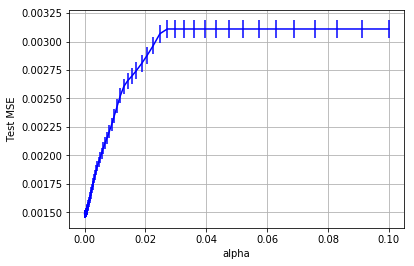

In [19]:
# Compute the mean and standard deviation over the different folds.
mse_mean = np.mean(mse,axis=1)
mse_std = np.std(mse,axis=1) / np.sqrt(nfold-1)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.errorbar(alphas, mse_mean,mse_std,color = 'b')
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

Find the optimal `alpha` and mean test RSS using the one standard error rule.

In [20]:
# Find the minimum MSE and MSE target
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_std[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)
print("the mean test RSS is:"), np.mean(mse[iopt,:]) 

Optimal alpha = 0.000722
the mean test RSS is: 0.00151409602736


Using the optimal alpha, recompute the predicted response variable on the whole data.  Plot the predicted vs. actual values.

       0 -0.0010268392953781
       1 0.0016120838252050
       2 0.0010416899600797
       3 0.0008907496625463
       4 0.0000000000000000
       5 0.0000000000000000
       6 0.0023846390068051
       7 0.0000000000000000
       8 0.0000000000000000
       9 0.0000000000000000
      10 -0.0002448978038360
      11 -0.0000000000000000
      12 0.0000000000000000
      13 -0.0000000000000000
      14 0.0000000000000000
      15 -0.0000000000000000
      16 0.0003210365532343
      17 -0.0000000000000000
      18 0.0001038739633533
      19 0.0000000000000000
      20 -0.0010956089023738
      21 0.0000000000000000
      22 -0.0029285992183480
      23 0.0004249526048747
      24 -0.0000000000000000
      25 -0.0000000000000000
      26 0.0011853368594875
      27 0.0000000000000000
      28 -0.0000000000000000
      29 0.0025778849658479
      30 0.0017801717066121
      31 -0.0000000000000000
      32 -0.0000000000000000
      33 -0.0000000000000000
      34 -0.0000000000000000
     

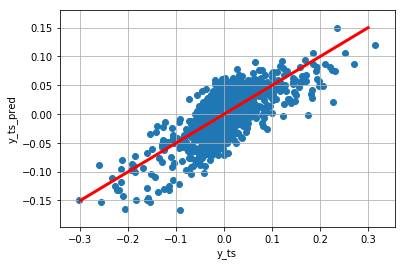

In [21]:
model.alpha = alpha_opt
model.fit(X_tr,y_tr)


#Print the coefficients
for i, c in enumerate(model.coef_):
    print("%8s %.16f" % (i, c))  
    
#Plot the predicted vs. actual values
y_ts_pred = X_ts.dot(model.coef_)
plt.scatter(y_ts,y_ts_pred)
plt.xlabel('y_ts')
plt.ylabel('y_ts_pred')
#plt.plot([np.min(y_ts),np.max(y_ts)], [np.min(y_ts_pred),np.max(y_ts_pred)], 'r-', linewidth=3)
plt.plot([-0.3,0.3], [-0.15,0.15], 'r-', linewidth=3)
plt.grid()

## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.

###Time lags

set y = beta0 + Beta1.dot(X[t]) + Beta2.dot(X[t-1]) + Beta3.dot(X[t-2])

In [22]:
nt,nneuron = X0.shape
print X0.shape
X0_d1 = np.vstack((np.zeros((1,nneuron)),np.delete(X0,[15535],axis = 0)))
X0_d2 = np.vstack((np.zeros((2,nneuron)),np.delete(X0,[15534,15535],axis = 0)))
X0_d = np.hstack((X0,X0_d1,X0_d2))
y0_d = y0

(15536L, 196L)


In [23]:
# Number of samples for training and test
nt,nneuron = X0_d.shape
ntr = nt // 2
nts = nt - ntr

# Training
Xtr = X0_d[:ntr]
ytr = y0_d[:ntr]
print Xtr.shape
print ytr.shape
# Test
Xts = X0_d[ntr:]
yts = y0_d[ntr:]

(7768L, 588L)
(7768L,)


In [24]:
regr = linear_model.LinearRegression()
regr.fit(Xtr,ytr)
yts_pred = regr.predict(Xts)
RSS_delay = np.mean((yts_pred-yts)**2)/(np.std(yts)**2)
print("Normalized RSS={0:f}".format(RSS))

Normalized RSS=0.514133


Parameter X include X for the moment, X[t-1] and X[t-2]. Do the same linear predict as we do at section 'Linear fitting on all the neurons', the normalized RSS is much much smaller than what we get in the first section.